# Self-Organizing Systems: Assignment 3 - Analysis of SOMs

Group 23:
- Florian Mende (12017067)
- Jan Widerhofer-Kaukal (11907081)

In [19]:
from scipy.io import arff
import pandas as pd
import numpy as np
import os
from som_toolbox import somtoolbox
from som_toolbox.SOMToolBox_Parse import SOMToolBox_Parse
from som_toolbox.somtoolbox import SOMToolbox
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from starvers.starvers import TripleStoreEngine
import uuid
import random
import datetime
import json
import seaborn as sns

In [2]:
executed_by ='stud-id_12017067'  # Replace the digits after "id_" with your own student ID

In [3]:
# # group id for this project
group_id = '23'  # Replace the digits with your group id

# # Students working on this notebook
student_a = 'stud-id_12017067'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_11907081'  # Replace the digits after "id_" with student B's student ID

In [4]:
# # Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

In [5]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/SOS2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/SOS2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

In [6]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

In [9]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Florian" .',
f':{student_a} foaf:familyName "Mende" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "01234567"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Jan" .',
f':{student_b} foaf:familyName "Widerhofer-Kaukal" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "76543210"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


# engine.insert(reigstration_triples_a, prefixes=prefixes)
# engine.insert(reigstration_triples_b, prefixes=prefixes)
# engine.insert(role_triples, prefixes=prefixes)

# B) Dataset

## 1) Select a dataset

We selected [credit_g](https://www.openml.org/search?type=data&sort=runs&id=31&status=active) dataset from OpenML. 


## 2) Register dataset
- Has been done in TUWEL

## 3) Create a machine-actionable description of the dataset using Crossant

Note: A Crossaint description of the dataset is available through OpenML, which we reuse here in parts to document the dataset.

In [10]:
def load_data():
    # Load the dataset
    data_path = os.path.join("data")
    data = arff.loadarff(os.path.join(data_path, "credit-g.arff"))

    # Convert the dataset to a pandas DataFrame
    df = pd.DataFrame(data[0])

    # Decode byte strings in object columns
    for col in df.select_dtypes([object]).columns:
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

    return df

In [11]:
start_time_ld = now()
df = load_data()
end_time_ld = now()

rnd = random.Random()
# use seed based on group id + 1 for each UUID generation + some high number
rnd.seed(327934+23+1)
ld_ass_uuid_executor = uuid.UUID(int=rnd.getrandbits(128), version=4)
load_data_executor = [
    f':load_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
#engine.insert(load_data_executor, prefixes=prefixes)

In [12]:
data_description_triples = [
    # Dataset Entity
    ':raw_data rdf:type prov:Entity .',
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data rdf:type cr:Dataset .',
    ':raw_data sc:name "credit-g" .',
    ':raw_data sc:version "1" .',
    ':raw_data sc:inLanguage "en" .',
    ':raw_data sc:license "Public" .',
    ':raw_data sc:isAccessibleForFree true .',
    ':raw_data sc:url <https://www.openml.org/d/31> .',
    ':raw_data sc:sameAs <https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)> .',
    ':raw_data <http://purl.org/dc/terms/conformsTo> <http://mlcommons.org/croissant/1.0> .',
    ':raw_data cr:citeAs <https://dl.acm.org/doi/abs/10.1145/967900.968104> .',
    ':raw_data sc:description "Classification dataset for credit risk assessment. Classifies people described by a set of attributes as good or bad credit risks. Contains 20 features including checking account status, credit history, loan purpose, credit amount, savings, employment, personal status, age, and other financial indicators." .',
    ':raw_data sc:dateCreated "2014-04-06T23:21:47"^^xsd:dateTime .',
    ':raw_data sc:datePublished "1994-11-17T00:00:00"^^xsd:dateTime .',
    
    # Attribution
    ':raw_data prov:wasAttributedTo :dr-hans-hofmann .',
    ':raw_data prov:wasGeneratedBy :dataset-creation-activity .',
    ':raw_data prov:wasDerivedFrom :uci-ml-repository .',
    ':raw_data prov:generatedAtTime "1994-11-17T00:00:00"^^xsd:dateTime .',
    ':raw_data prov:hadPrimarySource :uci-ml-repository .',
    
    # Creator Agent
    ':dr-hans-hofmann rdf:type prov:Agent .',
    ':dr-hans-hofmann rdf:type foaf:Person .',
    ':dr-hans-hofmann rdf:type sc:Person .',
    ':dr-hans-hofmann foaf:name "Dr. Hans Hofmann" .',
    ':dr-hans-hofmann sc:name "Dr. Hans Hofmann" .',
    
    # Source Repository
    ':uci-ml-repository rdf:type prov:Entity .',
    ':uci-ml-repository rdf:type sc:DataCatalog .',
    ':uci-ml-repository sc:name "UCI Machine Learning Repository" .',
    ':uci-ml-repository sc:url <https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)> .',
    ':uci-ml-repository <http://purl.org/dc/terms/description> "Source repository containing the original German Credit dataset" .',
    
    # Dataset Creation Activity
    ':dataset-creation-activity rdf:type prov:Activity .',
    ':dataset-creation-activity prov:startedAtTime "1994-11-17T00:00:00"^^xsd:dateTime .',
    ':dataset-creation-activity prov:endedAtTime "1994-11-17T00:00:00"^^xsd:dateTime .',
    ':dataset-creation-activity prov:wasAssociatedWith :dr-hans-hofmann .',
    ':dataset-creation-activity prov:used :uci-ml-repository .',
    ':dataset-creation-activity <http://purl.org/dc/terms/description> "Original creation and collection of German credit risk data" .',
    
    # Distribution - ARFF File (Local)
    ':credit-g-arff rdf:type cr:FileObject .',
    ':credit-g-arff rdf:type prov:Entity .',
    ':credit-g-arff rdf:type sc:DataDownload .',
    ':credit-g-arff sc:name "credit-g.arff" .',
    ':credit-g-arff sc:description "Local ARFF format distribution of the German Credit dataset" .',
    ':credit-g-arff sc:encodingFormat "text/arff" .',
    ':credit-g-arff cr:format "ARFF" .',
    ':credit-g-arff prov:wasDerivedFrom :raw_data .',
    ':raw_data sc:distribution :credit-g-arff .',
    
    # Record Set
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name "data-file-description" .',
    ':raw_recordset sc:description "Listing the fields of the data with 20 features and 1 target class" .',
    ':raw_recordset cr:source :credit-g-arff .',
    ':raw_data cr:recordSet :raw_recordset .',
    
    # Fields - All 20 features + 1 target
    ':raw_recordset cr:field :field-checking_status .',
    ':raw_recordset cr:field :field-duration .',
    ':raw_recordset cr:field :field-credit_history .',
    ':raw_recordset cr:field :field-purpose .',
    ':raw_recordset cr:field :field-credit_amount .',
    ':raw_recordset cr:field :field-savings_status .',
    ':raw_recordset cr:field :field-employment .',
    ':raw_recordset cr:field :field-installment_commitment .',
    ':raw_recordset cr:field :field-personal_status .',
    ':raw_recordset cr:field :field-other_parties .',
    ':raw_recordset cr:field :field-residence_since .',
    ':raw_recordset cr:field :field-property_magnitude .',
    ':raw_recordset cr:field :field-age .',
    ':raw_recordset cr:field :field-other_payment_plans .',
    ':raw_recordset cr:field :field-housing .',
    ':raw_recordset cr:field :field-existing_credits .',
    ':raw_recordset cr:field :field-job .',
    ':raw_recordset cr:field :field-num_dependents .',
    ':raw_recordset cr:field :field-own_telephone .',
    ':raw_recordset cr:field :field-foreign_worker .',
    ':raw_recordset cr:field :field-class .',
    
    # Field 0: checking_status
    ':field-checking_status rdf:type cr:Field .',
    ':field-checking_status sc:name "checking_status" .',
    ':field-checking_status sc:description "Status of existing checking account, in Deutsche Mark" .',
    ':field-checking_status cr:dataType sc:Text .',
    ':field-checking_status cr:source :credit-g-arff .',
    
    # Field 1: duration
    ':field-duration rdf:type cr:Field .',
    ':field-duration sc:name "duration" .',
    ':field-duration sc:description "Duration in months" .',
    ':field-duration cr:dataType sc:Integer .',
    ':field-duration cr:source :credit-g-arff .',
    
    # Field 2: credit_history
    ':field-credit_history rdf:type cr:Field .',
    ':field-credit_history sc:name "credit_history" .',
    ':field-credit_history sc:description "Credit history (credits taken, paid back duly, delays, critical accounts)" .',
    ':field-credit_history cr:dataType sc:Text .',
    ':field-credit_history cr:source :credit-g-arff .',
    
    # Field 3: purpose
    ':field-purpose rdf:type cr:Field .',
    ':field-purpose sc:name "purpose" .',
    ':field-purpose sc:description "Purpose of the credit (car, television, education, etc.)" .',
    ':field-purpose cr:dataType sc:Text .',
    ':field-purpose cr:source :credit-g-arff .',
    
    # Field 4: credit_amount
    ':field-credit_amount rdf:type cr:Field .',
    ':field-credit_amount sc:name "credit_amount" .',
    ':field-credit_amount sc:description "Credit amount in Deutsche Mark" .',
    ':field-credit_amount cr:dataType sc:Integer .',
    ':field-credit_amount cr:source :credit-g-arff .',
    
    # Field 5: savings_status
    ':field-savings_status rdf:type cr:Field .',
    ':field-savings_status sc:name "savings_status" .',
    ':field-savings_status sc:description "Status of savings account/bonds, in Deutsche Mark" .',
    ':field-savings_status cr:dataType sc:Text .',
    ':field-savings_status cr:source :credit-g-arff .',
    
    # Field 6: employment
    ':field-employment rdf:type cr:Field .',
    ':field-employment sc:name "employment" .',
    ':field-employment sc:description "Present employment, in number of years" .',
    ':field-employment cr:dataType sc:Text .',
    ':field-employment cr:source :credit-g-arff .',
    
    # Field 7: installment_commitment
    ':field-installment_commitment rdf:type cr:Field .',
    ':field-installment_commitment sc:name "installment_commitment" .',
    ':field-installment_commitment sc:description "Installment rate in percentage of disposable income" .',
    ':field-installment_commitment cr:dataType sc:Integer .',
    ':field-installment_commitment cr:source :credit-g-arff .',
    
    # Field 8: personal_status
    ':field-personal_status rdf:type cr:Field .',
    ':field-personal_status sc:name "personal_status" .',
    ':field-personal_status sc:description "Personal status (married, single, etc.) and sex" .',
    ':field-personal_status cr:dataType sc:Text .',
    ':field-personal_status cr:source :credit-g-arff .',
    
    # Field 9: other_parties
    ':field-other_parties rdf:type cr:Field .',
    ':field-other_parties sc:name "other_parties" .',
    ':field-other_parties sc:description "Other debtors / guarantors" .',
    ':field-other_parties cr:dataType sc:Text .',
    ':field-other_parties cr:source :credit-g-arff .',
    
    # Field 10: residence_since
    ':field-residence_since rdf:type cr:Field .',
    ':field-residence_since sc:name "residence_since" .',
    ':field-residence_since sc:description "Present residence since X years" .',
    ':field-residence_since cr:dataType sc:Integer .',
    ':field-residence_since cr:source :credit-g-arff .',
    
    # Field 11: property_magnitude
    ':field-property_magnitude rdf:type cr:Field .',
    ':field-property_magnitude sc:name "property_magnitude" .',
    ':field-property_magnitude sc:description "Property (e.g. real estate, car, life insurance)" .',
    ':field-property_magnitude cr:dataType sc:Text .',
    ':field-property_magnitude cr:source :credit-g-arff .',
    
    # Field 12: age
    ':field-age rdf:type cr:Field .',
    ':field-age sc:name "age" .',
    ':field-age sc:description "Age in years" .',
    ':field-age cr:dataType sc:Integer .',
    ':field-age cr:source :credit-g-arff .',
    
    # Field 13: other_payment_plans
    ':field-other_payment_plans rdf:type cr:Field .',
    ':field-other_payment_plans sc:name "other_payment_plans" .',
    ':field-other_payment_plans sc:description "Other installment plans (banks, stores)" .',
    ':field-other_payment_plans cr:dataType sc:Text .',
    ':field-other_payment_plans cr:source :credit-g-arff .',
    
    # Field 14: housing
    ':field-housing rdf:type cr:Field .',
    ':field-housing sc:name "housing" .',
    ':field-housing sc:description "Housing (rent, own, for free)" .',
    ':field-housing cr:dataType sc:Text .',
    ':field-housing cr:source :credit-g-arff .',
    
    # Field 15: existing_credits
    ':field-existing_credits rdf:type cr:Field .',
    ':field-existing_credits sc:name "existing_credits" .',
    ':field-existing_credits sc:description "Number of existing credits at this bank" .',
    ':field-existing_credits cr:dataType sc:Integer .',
    ':field-existing_credits cr:source :credit-g-arff .',
    
    # Field 16: job
    ':field-job rdf:type cr:Field .',
    ':field-job sc:name "job" .',
    ':field-job sc:description "Job status and qualification level" .',
    ':field-job cr:dataType sc:Text .',
    ':field-job cr:source :credit-g-arff .',
    
    # Field 17: num_dependents
    ':field-num_dependents rdf:type cr:Field .',
    ':field-num_dependents sc:name "num_dependents" .',
    ':field-num_dependents sc:description "Number of people being liable to provide maintenance for" .',
    ':field-num_dependents cr:dataType sc:Integer .',
    ':field-num_dependents cr:source :credit-g-arff .',
    
    # Field 18: own_telephone
    ':field-own_telephone rdf:type cr:Field .',
    ':field-own_telephone sc:name "own_telephone" .',
    ':field-own_telephone sc:description "Telephone (yes, no)" .',
    ':field-own_telephone cr:dataType sc:Text .',
    ':field-own_telephone cr:source :credit-g-arff .',
    
    # Field 19: foreign_worker
    ':field-foreign_worker rdf:type cr:Field .',
    ':field-foreign_worker sc:name "foreign_worker" .',
    ':field-foreign_worker sc:description "Foreign worker (yes, no)" .',
    ':field-foreign_worker cr:dataType sc:Text .',
    ':field-foreign_worker cr:source :credit-g-arff .',
    
    # Field 20: class (target variable)
    ':field-class rdf:type cr:Field .',
    ':field-class sc:name "class" .',
    ':field-class sc:description "Target classification: good or bad credit risk" .',
    ':field-class cr:dataType sc:Text .',
    ':field-class cr:source :credit-g-arff .',
    
    # File Object - ARFF Distribution
    ':credit-g-arff rdf:type cr:FileObject .',
    ':credit-g-arff rdf:type prov:Entity .',
    ':credit-g-arff rdf:type sc:DataDownload .',
    ':credit-g-arff sc:name "credit-g.arff" .',
    ':credit-g-arff sc:description "Local ARFF format distribution of the German Credit dataset" .',
    ':credit-g-arff sc:encodingFormat "text/arff" .',
    ':credit-g-arff cr:format "ARFF" .',
    ':credit-g-arff prov:wasDerivedFrom :raw_data .',
]
# engine.insert(data_description_triples, prefixes=prefixes)

## 4) Analyze and describe the characteristics of the dataset 

- size
- attribute types as discussed in class
- value ranges
- sparsity
- min/max values
- outliers
- missing values
- correlations
and describe this in the provenance graph. 

Also, describe any hypotheses you might have concerning the 
- distribution of the data, 
- number of clusters and their relationship, 
- majority/minority classes 
as rdf comment field in the provenance graph.

In [14]:
data_analysis = [
f':data_analysis_phase rdf:type prov:Activity .',
f':data_analysis_phase rdfs:label "Data Analysis Phase" .', 
]
# engine.insert(data_analysis, prefixes=prefixes)

In [54]:
#############################################
# Dataset Size
#############################################

# Size of loaded data
def get_data_size(df):
    return df.shape

start_time_data_size = now()
data_size_report = get_data_size(df)
print(f"Data size (number of records): {data_size_report}")
end_time_data_size = now()

# Activity: Check and create report
check_size_uuid_executor = "9f0dc14f-b18c-462c-97d0-e7582aaf19db"
check_size_uuid_writer = "66f0171b-eef4-4a71-b878-b28fea0a0133"
check_size_executor = [
    f':check_size prov:qualifiedAssociation :{check_size_uuid_executor} .',
    f':{check_size_uuid_executor} prov:agent :{executed_by} .',
    f':{check_size_uuid_executor} rdf:type prov:Association .',
    f':{check_size_uuid_executor} prov:hadRole :{code_executor_role} .',
]
# engine.insert(check_size_executor, prefixes=prefixes)

check_size_activity = [
    ':check_size rdf:type prov:Activity .',
    ':check_size sc:isPartOf :data_analysis_phase .',
    ':check_size rdfs:comment \'Check data size\' .',
    f':check_size rdfs:comment "Inspect the shape of the loaded dataset to determine the number of records and features." .', 
    f':check_size prov:startedAtTime "{start_time_data_size}"^^xsd:dateTime .',
    f':check_size prov:endedAtTime "{end_time_data_size}"^^xsd:dateTime .',
    f':check_size prov:qualifiedAssociation :{check_size_uuid_writer} .',
    f':{check_size_uuid_writer} prov:agent :{check_size_uuid_writer} .',
    f':{check_size_uuid_writer} rdf:type prov:Association .',
    f':{check_size_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_size prov:used :data .',
    ':check_size_report rdf:type prov:Entity .',
    f':check_size_report rdfs:comment """{data_size_report}""" .',
    ':check_size_report prov:wasGeneratedBy :check_size .',
]
# engine.insert(check_size_activity, prefixes=prefixes)

# Inspect activity outcome and derive decisions
insp_size_uuid_executor = "d3f5e1b3-4f3a-4e2e- ninth-8c4f-2c3b5e6f7a8b"
insp_size_report_executor = student_a

inspect_size_report_activity = [
    ':inspect_size_report rdf:type prov:Activity .',
    ':inspect_size_report rdfs:comment \'Inspect the dataset size.\' .',
    f':inspect_size_report rdfs:comment """The dataset contains 1000 rows and 21 dimensions of which one is the target variable.""" .', 
    f':inspect_size_report prov:startedAtTime "{start_time_data_size}"^^xsd:dateTime .',
    f':inspect_size_report prov:endedAtTime "{end_time_data_size}"^^xsd:dateTime .',
    f':inspect_size_report prov:qualifiedAssociation :{insp_size_uuid_executor} .',
    f':{insp_size_uuid_executor} prov:agent :{insp_size_report_executor} .',
    f':{insp_size_uuid_executor} rdf:type prov:Association .',
    f':{insp_size_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_size_report prov:used :check_size_report .',
    # no decision needed here
]
# engine.insert(inspect_size_report_activity, prefixes=prefixes)


Data size (number of records): (1000, 21)


In [15]:
#############################################
# ATTRIBUTE TYPES ANALYSIS
#############################################

def get_attribute_types(df):
    """Analyze attribute types"""
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=[object]).columns.tolist()
    
    type_details = {}
    for col in df.columns:
        unique_count = df[col].nunique()
        dtype = str(df[col].dtype)
        if dtype == 'object':
            type_details[col] = {"type": "categorical", "unique_values": unique_count}
        elif dtype in ['int64', 'float64']:
            if unique_count <= 10:
                type_details[col] = {"type": "discrete", "unique_values": unique_count}
            else:
                type_details[col] = {"type": "continuous", "unique_values": unique_count}
    
    return {
        "numerical_count": len(numerical_cols),
        "categorical_count": len(categorical_cols),
        "type_details": type_details
    }

start_time_attr_types = now()
attr_types_report = get_attribute_types(df)
print(f"Numerical attributes: {attr_types_report['numerical_count']}")
print(f"Categorical attributes: {attr_types_report['categorical_count']}")
end_time_attr_types = now()

# Activity: Analyze attribute types
check_types_uuid_executor = "c1d6c7b9-7c5e-4c76-9345-2fbc3655d90b"
check_types_uuid_writer = "c1d6c7b9-7c5e-4c76-9345-2fbc3655d90b"

check_types_activity = [
    ':check_attribute_types rdf:type prov:Activity .',
    ':check_attribute_types sc:isPartOf :data_analysis_phase .',
    ':check_attribute_types rdfs:comment "Analyze attribute types" .',
    ':check_attribute_types rdfs:comment "Classify each feature as numerical (continuous/discrete) or categorical to understand data structure." .',
    f':check_attribute_types prov:startedAtTime "{start_time_attr_types}"^^xsd:dateTime .',
    f':check_attribute_types prov:endedAtTime "{end_time_attr_types}"^^xsd:dateTime .',
    f':check_attribute_types prov:qualifiedAssociation :{check_types_uuid_executor} .',
    f':{check_types_uuid_executor} prov:agent :{executed_by} .',
    f':{check_types_uuid_executor} rdf:type prov:Association .',
    f':{check_types_uuid_executor} prov:hadRole :{code_executor_role} .',
    f':check_attribute_types prov:qualifiedAssociation :{check_types_uuid_writer} .',
    f':{check_types_uuid_writer} prov:agent :{student_a} .',
    f':{check_types_uuid_writer} rdf:type prov:Association .',
    f':{check_types_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_attribute_types prov:used :raw_data .',
    ':attribute_types_report rdf:type prov:Entity .',
    f':attribute_types_report rdfs:comment "Found {attr_types_report["numerical_count"]} numerical and {attr_types_report["categorical_count"]} categorical attributes" .',
    ':attribute_types_report prov:wasGeneratedBy :check_attribute_types .',
]
# engine.insert(check_types_activity, prefixes=prefixes)

# Inspect attribute types
insp_types_uuid_executor = "c3d4e5f6-a7b8-4c9d-0e1f-2a3b4c5d6e7f"

inspect_types_activity = [
    ':inspect_attribute_types rdf:type prov:Activity .',
    ':inspect_attribute_types rdfs:comment "Inspect attribute types distribution" .',
    f':inspect_attribute_types rdfs:comment "Dataset has mixed types with {attr_types_report["numerical_count"]} numerical and {attr_types_report["categorical_count"]} categorical features. Categorical features will require encoding for SOM training." .',
    f':inspect_attribute_types prov:startedAtTime "{start_time_attr_types}"^^xsd:dateTime .',
    f':inspect_attribute_types prov:endedAtTime "{end_time_attr_types}"^^xsd:dateTime .',
    f':inspect_attribute_types prov:qualifiedAssociation :{insp_types_uuid_executor} .',
    f':{insp_types_uuid_executor} prov:agent :{student_a} .',
    f':{insp_types_uuid_executor} rdf:type prov:Association .',
    f':{insp_types_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_attribute_types prov:used :attribute_types_report .',
    ':decision_encode_categorical rdf:type prov:Entity .',
    ':decision_encode_categorical rdfs:comment "Decision: Apply ordinal encoding to categorical variables before training a SOM to preserve meaningful order where applicable" .',
    ':decision_encode_categorical prov:wasGeneratedBy :inspect_attribute_types .',
]
# engine.insert(inspect_types_activity, prefixes=prefixes)

Numerical attributes: 7
Categorical attributes: 14


In [16]:
#############################################
# VALUE RANGES ANALYSIS
#############################################
def get_value_ranges(df):
    """Analyze value ranges for numerical features"""
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    ranges = {}
    for col in numerical_cols:
        ranges[col] = {
            "min": float(df[col].min()),
            "max": float(df[col].max()),
            "range": float(df[col].max() - df[col].min()),
            "mean": float(df[col].mean()),
            "std": float(df[col].std())
        }
    return ranges

start_time_ranges = now()
ranges_report = get_value_ranges(df)
print(f"Analyzed value ranges for {len(ranges_report)} numerical features")
for col, stats in ranges_report.items():
    print(f"  {col}: [{stats['min']:.2f}, {stats['max']:.2f}], range={stats['range']:.2f}")
end_time_ranges = now()

# Activity: Analyze value ranges
check_ranges_uuid_executor = "d8a679e7-616a-41f6-8519-41f44da5a6cb"
check_ranges_uuid_writer = "a0c22b09-317c-4ff7-8d9c-adc78e83a2a0"

check_ranges_activity = [
    ':check_value_ranges rdf:type prov:Activity .',
    ':check_value_ranges sc:isPartOf :data_analysis_phase .',
    ':check_value_ranges rdfs:comment "Analyze value ranges" .',
    ':check_value_ranges rdfs:comment "Determine min, max, and range for numerical features to understand data distribution and scaling needs." .',
    f':check_value_ranges prov:startedAtTime "{start_time_ranges}"^^xsd:dateTime .',
    f':check_value_ranges prov:endedAtTime "{end_time_ranges}"^^xsd:dateTime .',
    f':check_value_ranges prov:qualifiedAssociation :{check_ranges_uuid_executor} .',
    f':{check_ranges_uuid_executor} prov:agent :{executed_by} .',
    f':{check_ranges_uuid_executor} rdf:type prov:Association .',
    f':{check_ranges_uuid_executor} prov:hadRole :{code_executor_role} .',
    f':check_value_ranges prov:qualifiedAssociation :{check_ranges_uuid_writer} .',
    f':{check_ranges_uuid_writer} prov:agent :{student_a} .',
    f':{check_ranges_uuid_writer} rdf:type prov:Association .',
    f':{check_ranges_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_value_ranges prov:used :raw_data .',
    ':value_ranges_report rdf:type prov:Entity .',
    f':value_ranges_report rdfs:comment "Analyzed ranges for {len(ranges_report)} numerical features with varying scales" .',
    ':value_ranges_report prov:wasGeneratedBy :check_value_ranges .',
]
# engine.insert(check_ranges_activity, prefixes=prefixes)

# Inspect value ranges
insp_ranges_uuid_executor = "e65b20e0-212f-40e0-acc6-b11fe2182050"

inspect_ranges_activity = [
    ':inspect_value_ranges rdf:type prov:Activity .',
    ':inspect_value_ranges rdfs:comment "Inspect value ranges" .',
    ':inspect_value_ranges rdfs:comment "Features have different scales (e.g., age 19-75, credit_amount 250-18424, duration 4-72). Different scales require normalization for SOM training to prevent features with larger ranges from dominating distance calculations." .',
    f':inspect_value_ranges prov:startedAtTime "{start_time_ranges}"^^xsd:dateTime .',
    f':inspect_value_ranges prov:endedAtTime "{end_time_ranges}"^^xsd:dateTime .',
    f':inspect_value_ranges prov:qualifiedAssociation :{insp_ranges_uuid_executor} .',
    f':{insp_ranges_uuid_executor} prov:agent :{student_a} .',
    f':{insp_ranges_uuid_executor} rdf:type prov:Association .',
    f':{insp_ranges_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_value_ranges prov:used :value_ranges_report .',
    ':decision_normalize_data rdf:type prov:Entity .',
    ':decision_normalize_data rdfs:comment "Raw numerical features are not standardized/scaled. Decision: Apply MinMax scaling to normalize all features to [0,1] range for fair distance computation in SOM" .',
    ':decision_normalize_data prov:wasGeneratedBy :inspect_value_ranges .',
]
# engine.insert(inspect_ranges_activity, prefixes=prefixes)

Analyzed value ranges for 7 numerical features
  duration: [4.00, 72.00], range=68.00
  credit_amount: [250.00, 18424.00], range=18174.00
  installment_commitment: [1.00, 4.00], range=3.00
  residence_since: [1.00, 4.00], range=3.00
  age: [19.00, 75.00], range=56.00
  existing_credits: [1.00, 4.00], range=3.00
  num_dependents: [1.00, 2.00], range=1.00


In [17]:
#############################################
# MISSING VALUES ANALYSIS
#############################################

def check_missing_values(df):
    """Check for missing values"""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    return {
        "total_missing": int(missing.sum()),
        "columns_with_missing": list(missing[missing > 0].index),
        "missing_percentages": {col: float(pct) for col, pct in missing_pct[missing_pct > 0].items()}
    }

start_time_missing = now()
missing_report = check_missing_values(df)
print(f"Total missing values: {missing_report['total_missing']}")
if missing_report['total_missing'] == 0:
    print("✓ No missing values detected in the dataset")
end_time_missing = now()

# Activity: Check missing values
check_missing_uuid_executor = "3c881dde-4745-47ce-ac98-44e26885c1c9"
check_missing_uuid_writer = "dba52635-6c0d-4a1c-85e7-0461fde928b1"

check_missing_activity = [
    ':check_missing_values rdf:type prov:Activity .',
    ':check_missing_values sc:isPartOf :data_analysis_phase .',
    ':check_missing_values rdfs:comment "Check for missing values" .',
    ':check_missing_values rdfs:comment "Identify any missing or null values in the dataset that may require imputation or removal." .',
    f':check_missing_values prov:startedAtTime "{start_time_missing}"^^xsd:dateTime .',
    f':check_missing_values prov:endedAtTime "{end_time_missing}"^^xsd:dateTime .',
    f':check_missing_values prov:qualifiedAssociation :{check_missing_uuid_executor} .',
    f':{check_missing_uuid_executor} prov:agent :{executed_by} .',
    f':{check_missing_uuid_executor} rdf:type prov:Association .',
    f':{check_missing_uuid_executor} prov:hadRole :{code_executor_role} .',
    f':check_missing_values prov:qualifiedAssociation :{check_missing_uuid_writer} .',
    f':{check_missing_uuid_writer} prov:agent :{student_a} .',
    f':{check_missing_uuid_writer} rdf:type prov:Association .',
    f':{check_missing_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_missing_values prov:used :raw_data .',
    ':missing_values_report rdf:type prov:Entity .',
    f':missing_values_report rdfs:comment "Found {missing_report["total_missing"]} missing values in dataset" .',
    ':missing_values_report prov:wasGeneratedBy :check_missing_values .',
]
# engine.insert(check_missing_activity, prefixes=prefixes)

# Inspect missing values
insp_missing_uuid_executor = "c9d0e1f2-a3b4-4c5d-6e7f-8a9b0c1d2e3f"

inspect_missing_activity = [
    ':inspect_missing_values rdf:type prov:Activity .',
    ':inspect_missing_values rdfs:comment "Inspect missing values" .',
    ':inspect_missing_values rdfs:comment "No missing values detected in the dataset. Data is complete and ready for analysis without imputation." .',
    f':inspect_missing_values prov:startedAtTime "{start_time_missing}"^^xsd:dateTime .',
    f':inspect_missing_values prov:endedAtTime "{end_time_missing}"^^xsd:dateTime .',
    f':inspect_missing_values prov:qualifiedAssociation :{insp_missing_uuid_executor} .',
    f':{insp_missing_uuid_executor} prov:agent :{student_a} .',
    f':{insp_missing_uuid_executor} rdf:type prov:Association .',
    f':{insp_missing_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_missing_values prov:used :missing_values_report .',
]
# engine.insert(inspect_missing_activity, prefixes=prefixes)

Total missing values: 0
✓ No missing values detected in the dataset


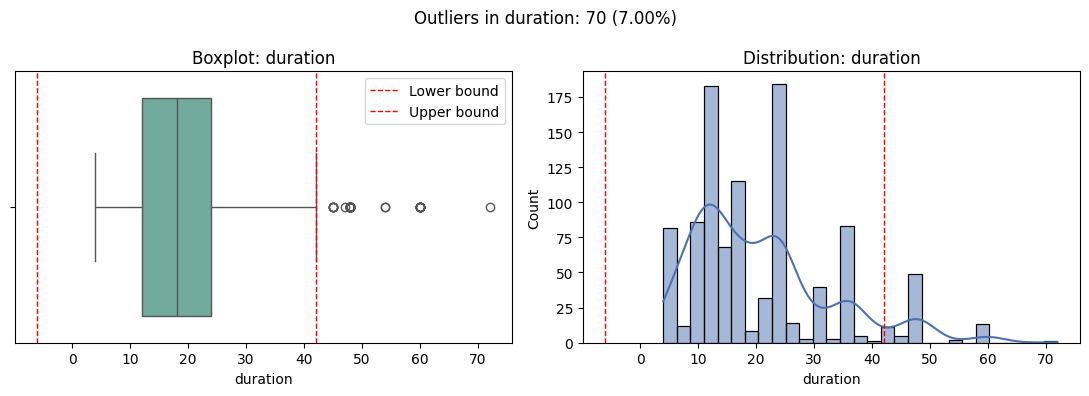

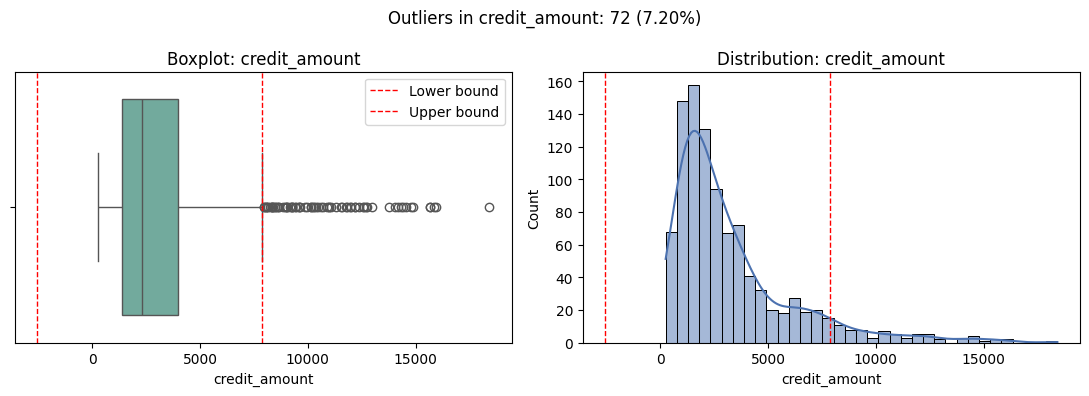

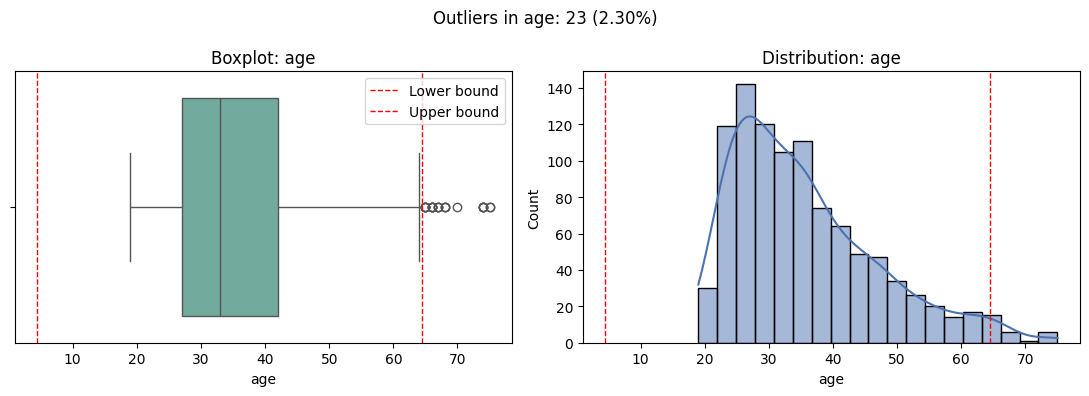

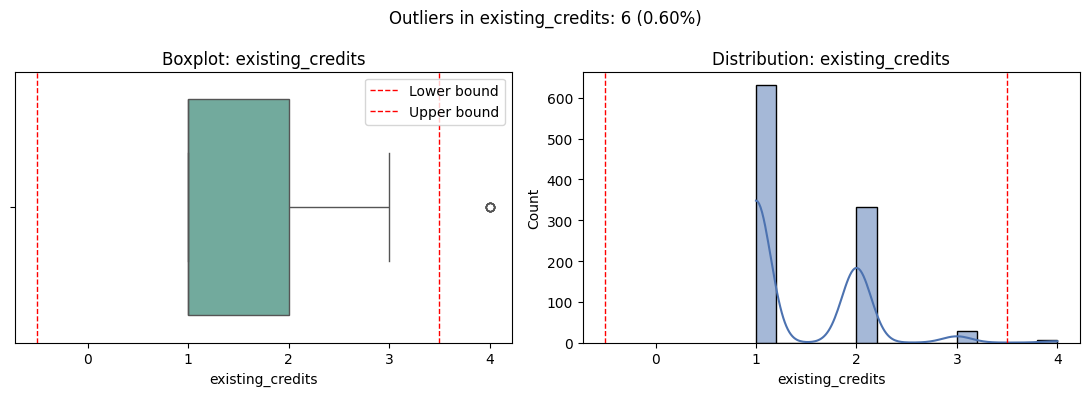

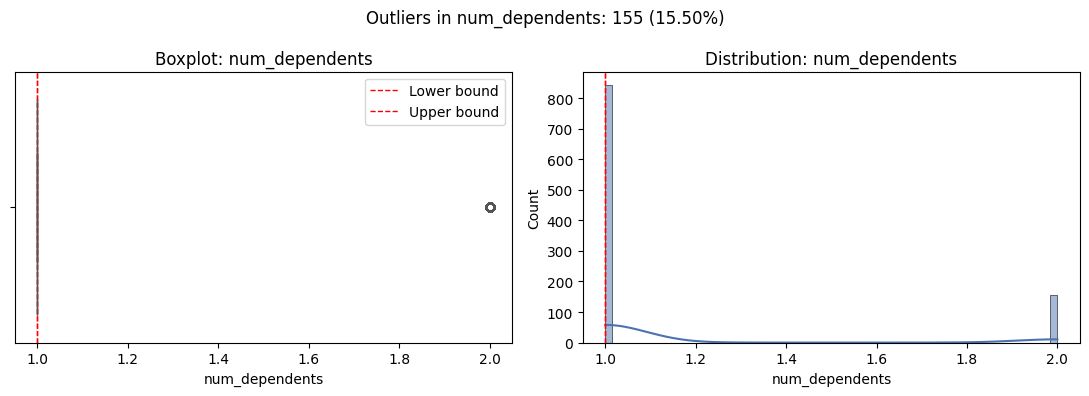

Features with outliers: 5
  duration: 70 outliers (7.00%)
  credit_amount: 72 outliers (7.20%)
  age: 23 outliers (2.30%)
  existing_credits: 6 outliers (0.60%)
  num_dependents: 155 outliers (15.50%)


In [20]:
#############################################
# OUTLIER DETECTION
#############################################

def detect_outliers_iqr(
    df,
    plot: bool = True,
    show: bool = True,
    max_plots: int = 20,
):
    """Detect outliers using IQR method and optionally plot affected columns.
    """
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    outlier_summary = {}

    # Prepare plotting directory if plotting is enabled
    plots_done = 0

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Skip plotting for non-varying columns
        if IQR == 0:
            lower_bound = Q1
            upper_bound = Q3
        else:
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100

        if outlier_count > 0:
            entry = {
                "count": int(outlier_count),
                "percentage": float(outlier_pct),
                "lower_bound": float(lower_bound),
                "upper_bound": float(upper_bound),
            }

            # Generate plots for detailed inspection
            if plot and plots_done < max_plots:
                fig, axes = plt.subplots(1, 2, figsize=(11, 4))
                fig.suptitle(f"Outliers in {col}: {outlier_count} ({outlier_pct:.2f}%)")

                # Boxplot with bounds
                sns.boxplot(x=df[col], ax=axes[0], color="#69b3a2")
                axes[0].axvline(lower_bound, color="red", linestyle="--", linewidth=1, label="Lower bound")
                axes[0].axvline(upper_bound, color="red", linestyle="--", linewidth=1, label="Upper bound")
                axes[0].set_title(f"Boxplot: {col}")
                axes[0].legend(loc="best")

                # Histogram/KDE with bounds
                sns.histplot(df[col], kde=True, ax=axes[1], color="#4c72b0")
                axes[1].axvline(lower_bound, color="red", linestyle="--", linewidth=1)
                axes[1].axvline(upper_bound, color="red", linestyle="--", linewidth=1)
                axes[1].set_title(f"Distribution: {col}")

                plt.tight_layout()
                if show:
                    plt.show()
                plt.close(fig)
                plots_done += 1

            outlier_summary[col] = entry

    return outlier_summary

start_time_outliers = now()
outliers_report = detect_outliers_iqr(df)
print(f"Features with outliers: {len(outliers_report)}")
for col, stats in outliers_report.items():
    print(f"  {col}: {stats['count']} outliers ({stats['percentage']:.2f}%)")
end_time_outliers = now()

# Activity: Detect outliers
check_outliers_uuid_executor = "6dcfa393-751c-45fc-9317-6f159c35d373"
check_outliers_uuid_writer = "64cb130e-cd9d-4b83-9dd9-9400c6c987b4"

check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_analysis_phase .',
    ':check_outliers rdfs:comment "Detect outliers using IQR method" .',
    ':check_outliers rdfs:comment "Apply IQR-based outlier detection to identify anomalous values that may affect SOM training." .',
    f':check_outliers prov:startedAtTime "{start_time_outliers}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_outliers}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{check_outliers_uuid_executor} .',
    f':{check_outliers_uuid_executor} prov:agent :{executed_by} .',
    f':{check_outliers_uuid_executor} rdf:type prov:Association .',
    f':{check_outliers_uuid_executor} prov:hadRole :{code_executor_role} .',
    f':check_outliers prov:qualifiedAssociation :{check_outliers_uuid_writer} .',
    f':{check_outliers_uuid_writer} prov:agent :{student_a} .',
    f':{check_outliers_uuid_writer} rdf:type prov:Association .',
    f':{check_outliers_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :raw_data .',
    ':outliers_report rdf:type prov:Entity .',
    f':outliers_report rdfs:comment "Detected outliers in {len(outliers_report)} features using IQR method" .',
    ':outliers_report prov:wasGeneratedBy :check_outliers .',
]
# engine.insert(check_outliers_activity, prefixes=prefixes)

# Inspect outliers
insp_outliers_uuid_executor = "f2a3b4c5-d6e7-4f8a-9b0c-1d2e3f4a5b6c"

outlier_interpretation = "Outliers detected in several features. For credit risk data, these may represent legitimate extreme cases (e.g., very high credit amounts, long durations). SOMs are relatively robust to outliers as they perform vector quantization. Decision: Keep outliers as they may represent important edge cases in credit assessment."


inspect_outliers_activity = [
    ':inspect_outliers rdf:type prov:Activity .',
    ':inspect_outliers rdfs:comment "Inspect outlier detection results" .',
    f':inspect_outliers rdfs:comment "{outlier_interpretation}" .',
    f':inspect_outliers prov:startedAtTime "{start_time_outliers}"^^xsd:dateTime .',
    f':inspect_outliers prov:endedAtTime "{end_time_outliers}"^^xsd:dateTime .',
    f':inspect_outliers prov:qualifiedAssociation :{insp_outliers_uuid_executor} .',
    f':{insp_outliers_uuid_executor} prov:agent :{student_a} .',
    f':{insp_outliers_uuid_executor} rdf:type prov:Association .',
    f':{insp_outliers_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outliers prov:used :outliers_report .',
    ':decision_keep_outliers rdf:type prov:Entity .',
    ':decision_keep_outliers rdfs:comment "Decision: Retain outliers. Although they are classified as outliers based on IQR, looking at the distribution plots reveals, that acutally none of the observations can be considered "real" outliers, as they often still follow the overall distribution pattern." .',
    ':decision_keep_outliers prov:wasGeneratedBy :inspect_outliers .',
]
# engine.insert(check_outliers_activity, prefixes=prefixes)

In [21]:
#############################################
# CORRELATION ANALYSIS
#############################################

def analyze_correlations(df):
    """Analyze correlations between numerical features"""
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numerical_cols) > 1:
        corr_matrix = df[numerical_cols].corr()
        
        # Find high correlations
        high_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_value = corr_matrix.iloc[i, j]
                if abs(corr_value) > 0.5:
                    high_corr.append({
                        'feature1': corr_matrix.columns[i],
                        'feature2': corr_matrix.columns[j],
                        'correlation': float(corr_value)
                    })
        
        return {
            "high_correlations": high_corr,
            "correlation_count": len(high_corr)
        }
    else:
        return {"high_correlations": [], "correlation_count": 0}

start_time_corr = now()
corr_report = analyze_correlations(df)
print(f"High correlations (|r| > 0.5): {corr_report['correlation_count']}")
for corr in corr_report['high_correlations']:
    print(f"  {corr['feature1']} <-> {corr['feature2']}: r={corr['correlation']:.3f}")
end_time_corr = now()

# Activity: Analyze correlations
check_corr_uuid_executor = "6f1ee6fc-1cc0-47de-927a-55ec236d06de"
check_corr_uuid_writer = "417c7640-a97e-41bb-a333-49dc165b388a"

check_corr_activity = [
    ':check_correlations rdf:type prov:Activity .',
    ':check_correlations sc:isPartOf :data_analysis_phase .',
    ':check_correlations rdfs:comment "Analyze feature correlations" .',
    ':check_correlations rdfs:comment "Compute pairwise correlations between numerical features to identify redundant or highly related features." .',
    f':check_correlations prov:startedAtTime "{start_time_corr}"^^xsd:dateTime .',
    f':check_correlations prov:endedAtTime "{end_time_corr}"^^xsd:dateTime .',
    f':check_correlations prov:qualifiedAssociation :{check_corr_uuid_executor} .',
    f':{check_corr_uuid_executor} prov:agent :{executed_by} .',
    f':{check_corr_uuid_executor} rdf:type prov:Association .',
    f':{check_corr_uuid_executor} prov:hadRole :{code_executor_role} .',
    f':check_correlations prov:qualifiedAssociation :{check_corr_uuid_writer} .',
    f':{check_corr_uuid_writer} prov:agent :{student_a} .',
    f':{check_corr_uuid_writer} rdf:type prov:Association .',
    f':{check_corr_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_correlations prov:used :raw_data .',
    ':correlations_report rdf:type prov:Entity .',
    f':correlations_report rdfs:comment "Found {corr_report["correlation_count"]} high correlations (|r| > 0.5) between numerical features" .',
    ':correlations_report prov:wasGeneratedBy :check_correlations .',
]
# engine.insert(check_corr_activity, prefixes=prefixes)

# Inspect correlations
insp_corr_uuid_executor = "c5d6e7f8-a9b0-4c1d-2e3f-4a5b6c7d8e9f"

corr_interpretation = f"Found {corr_report['correlation_count']} high correlations. For SOM analysis, we retain all features as SOMs can handle correlated features and the visualization may reveal interesting relationships. Feature reduction would be considered only if computational constraints arise."

inspect_corr_activity = [
    ':inspect_correlations rdf:type prov:Activity .',
    ':inspect_correlations rdfs:comment "Inspect correlation analysis results" .',
    f':inspect_correlations rdfs:comment "{corr_interpretation}" .',
    f':inspect_correlations prov:startedAtTime "{start_time_corr}"^^xsd:dateTime .',
    f':inspect_correlations prov:endedAtTime "{end_time_corr}"^^xsd:dateTime .',
    f':inspect_correlations prov:qualifiedAssociation :{insp_corr_uuid_executor} .',
    f':{insp_corr_uuid_executor} prov:agent :{student_a} .',
    f':{insp_corr_uuid_executor} rdf:type prov:Association .',
    f':{insp_corr_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_correlations prov:used :correlations_report .',
    ':decision_keep_all_features rdf:type prov:Entity .',
    ':decision_keep_all_features rdfs:comment "We only observe high correlation between duration <-> credit_amount, which is expected (i.e. higher credit amounts are often paid off over longer durations). Decision: Retain all features for SOM training." .',
    ':decision_keep_all_features prov:wasGeneratedBy :inspect_correlations .',
]
# engine.insert(inspect_corr_activity, prefixes=prefixes)

High correlations (|r| > 0.5): 1
  duration <-> credit_amount: r=0.625


In [23]:
#############################################
# CLASS DISTRIBUTION ANALYSIS
#############################################

def analyze_class_distribution(df):
    """Analyze target class distribution"""
    if 'class' in df.columns:
        class_counts = df['class'].value_counts()
        class_pcts = (class_counts / len(df)) * 100
        imbalance_ratio = class_counts.max() / class_counts.min()
        
        return {
            "classes": {cls: int(count) for cls, count in class_counts.items()},
            "percentages": {cls: float(pct) for cls, pct in class_pcts.items()},
            "imbalance_ratio": float(imbalance_ratio),
            "is_imbalanced": bool(imbalance_ratio > 1.5)
        }
    return None

start_time_class = now()
class_report = analyze_class_distribution(df)
if class_report:
    print(f"Class distribution:")
    for cls, count in class_report['classes'].items():
        print(f"  {cls}: {count} ({class_report['percentages'][cls]:.1f}%)")
    print(f"Imbalance ratio: {class_report['imbalance_ratio']:.2f}:1")
end_time_class = now()

# Activity: Analyze class distribution
check_class_uuid_executor = "b9aec941-19e7-4789-bcf9-241b68b26147"
check_class_uuid_writer = "0a626562-d24f-44a4-9f96-d2a2ae968206"

check_class_activity = [
    ':check_class_distribution rdf:type prov:Activity .',
    ':check_class_distribution sc:isPartOf :data_analysis_phase .',
    ':check_class_distribution rdfs:comment "Analyze target class distribution" .',
    ':check_class_distribution rdfs:comment "Examine the balance between good and bad credit risk classes to identify potential class imbalance issues." .',
    f':check_class_distribution prov:startedAtTime "{start_time_class}"^^xsd:dateTime .',
    f':check_class_distribution prov:endedAtTime "{end_time_class}"^^xsd:dateTime .',
    f':check_class_distribution prov:qualifiedAssociation :{check_class_uuid_executor} .',
    f':{check_class_uuid_executor} prov:agent :{executed_by} .',
    f':{check_class_uuid_executor} rdf:type prov:Association .',
    f':{check_class_uuid_executor} prov:hadRole :{code_executor_role} .',
    f':check_class_distribution prov:qualifiedAssociation :{check_class_uuid_writer} .',
    f':{check_class_uuid_writer} prov:agent :{student_a} .',
    f':{check_class_uuid_writer} rdf:type prov:Association .',
    f':{check_class_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_class_distribution prov:used :raw_data .',
    ':class_distribution_report rdf:type prov:Entity .',
    f':class_distribution_report rdfs:comment "Class imbalance ratio: {class_report["imbalance_ratio"]:.2f}:1" .',
    ':class_distribution_report prov:wasGeneratedBy :check_class_distribution .',
]
# engine.insert(check_class_activity, prefixes=prefixes)

# Inspect class distribution
insp_class_uuid_executor = "f8a9b0c1-d2e3-4f4a-5b6c-7d8e9f0a1b2c"

class_interpretation = f"Dataset shows class imbalance with ratio {class_report['imbalance_ratio']:.2f}:1. The majority class (good credit) represents about {max(class_report['percentages'].values()):.1f}% of samples. For SOM analysis, this imbalance will be visible in class distribution visualizations and may affect cluster purity."

inspect_class_activity = [
    ':inspect_class_distribution rdf:type prov:Activity .',
    ':inspect_class_distribution rdfs:comment "Inspect class distribution" .',
    f':inspect_class_distribution rdfs:comment "{class_interpretation}" .',
    f':inspect_class_distribution prov:startedAtTime "{start_time_class}"^^xsd:dateTime .',
    f':inspect_class_distribution prov:endedAtTime "{end_time_class}"^^xsd:dateTime .',
    f':inspect_class_distribution prov:qualifiedAssociation :{insp_class_uuid_executor} .',
    f':{insp_class_uuid_executor} prov:agent :{student_a} .',
    f':{insp_class_uuid_executor} rdf:type prov:Association .',
    f':{insp_class_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_class_distribution prov:used :class_distribution_report .',
    ':hypothesis_cluster_structure rdf:type prov:Entity .',
    ':hypothesis_cluster_structure rdfs:comment "Skewed class distribution with higher amounts of good credits is expected in this credit risk setting. With an imbalance of 2.33, this ratio is still acceptable not to extremly skewed. Hypothesis: Expect to see majority class dominating most SOM units with minority class potentially forming smaller, more concentrated clusters." .',
    ':hypothesis_cluster_structure prov:wasGeneratedBy :inspect_class_distribution .',
]
# engine.insert(inspect_class_activity, prefixes=prefixes)

Class distribution:
  good: 700 (70.0%)
  bad: 300 (30.0%)
Imbalance ratio: 2.33:1


In [24]:
#############################################
# HYPOTHESES
#############################################

hyp_start = now()
hyp_end = now()
hypotheses_activity = [
    ':formulate_hypotheses rdf:type prov:Activity .',
    ':formulate_hypotheses sc:isPartOf :data_analysis_phase .',
    ':formulate_hypotheses rdfs:label "Formulate Hypotheses" .',
    ':formulate_hypotheses rdfs:comment "High-level hypotheses to guide SOM exploration" .',
    f':formulate_hypotheses prov:startedAtTime "{hyp_start}"^^xsd:dateTime .',
    f':formulate_hypotheses prov:endedAtTime "{hyp_end}"^^xsd:dateTime .',
    ':hypothesis_data_distribution rdf:type prov:Entity .',
    f':hypothesis_data_distribution rdfs:comment "Features like duration and credit_amount are right-skewed. Most loans in the dataset tend to be for smaller amounts and shorter durations, with a long tail representing high-risk, high-value loans." .',
    f':hypothesis_data_distribution rdfs:comment "Age variable is skewed toward younger to middle-aged adults (25–45), as this demographic is historically the most active in seeking credit." .',
    ':hypothesis_data_distribution prov:wasGeneratedBy :formulate_hypotheses .',
    ':hypothesis_cluster_structure_simple rdf:type prov:Entity .',
    f':hypothesis_cluster_structure_simple rdfs:comment "We might see distinct clusters corresponding to different personas, e.g., low-risk young adults, high-risk older adults, etc." .',
    ':hypothesis_cluster_structure_simple prov:wasGeneratedBy :formulate_hypotheses .',
    ':hypothesis_class_balance rdf:type prov:Entity .',
    f':hypothesis_class_balance rdfs:comment "Because these classes are not drastically imbalanced but share many overlapping feature distributions, the hypothesis is that the decision boundary is complex and cannot be easily separated by linear models alone." .',
    ':hypothesis_class_balance prov:wasGeneratedBy :formulate_hypotheses .',
]
# engine.insert(hypotheses_activity, prefixes=prefixes)

## 5) Preprocessing

Get the data into the form needed for training SOMs. 

Describe your preprocessing steps (e.g. transcoding, scaling), why you did it and how you did it. 
Specifically, if your dataset turns out to be extremely large (very high-dimensional and huge number of vectors so that it does not fit into memory for training SOMs) you may choose to apply subsampling for the training data.

Steps we took:
- Transformed categorical features into numerical ones manual mapping that perserves ordinality where applicable.
- Encode binary features as 0/1 (including target variable) as 0/1.

In [5]:
print("=== Categorical Columns and Unique Values ===\n")
categorical_cols = df.select_dtypes([object]).columns.tolist()
for col in categorical_cols:
    unique_vals = sorted(df[col].unique())
    print(f"{col}: {unique_vals}\n")

df_encoded = df.copy()

# Define ordinal mappings
ordinal_mappings = {
    # Checking status: worst (negative) to best
    'checking_status': {
        '<0': 0,              # Negative balance - worst
        '0<=X<200': 1,        # Low positive balance
        '>=200': 2,           # Good balance
        'no checking': 3      # No checking account - can be best or neutral
    },
    
    # Savings status: lowest to highest savings
    'savings_status': {
        'no known savings': 0,    # No savings - worst
        '<100': 1,                # Very low savings
        '100<=X<500': 2,          # Low savings
        '500<=X<1000': 3,         # Moderate savings
        '>=1000': 4               # High savings - best
    },
    
    # Employment: worst (unemployed) to best (long-term employed)
    'employment': {
        'unemployed': 0,          # Unemployed - worst
        '<1': 1,                  # Less than 1 year
        '1<=X<4': 2,              # 1 to 4 years
        '4<=X<7': 3,              # 4 to 7 years
        '>=7': 4                  # 7+ years - best (most stable)
    },
    
    # Property magnitude: value from lowest to highest (note: column name is 'property_magnitude')
    'property_magnitude': {
        'no known property': 0,   # No property - worst
        'car': 1,                 # Car (moderate value)
        'life insurance': 2,      # Life insurance (better)
        'real estate': 3          # Real estate - best (highest value)
    },
    
    # Job quality: worst to best
    'job': {
        'unemp/unskilled non res': 0,
        'unskilled resident': 1,                   # Low skill
        'skilled': 2,                              # Skilled worker
        'high qualif/self emp/mgmt': 3             # Best (management/high qualification)
    },
    
    # Credit history: worst (critical) to best (all paid, no credits)
    'credit_history': {
        'critical/other existing credit': 0,       # Critical - worst
        'existing paid': 1,                        # Paid but existing
        'delayed previously': 2,                   # Had delays
        'all paid': 3,                             # All paid
        'no credits/all paid': 4                   # Best - no previous issues (FIXED)
    },
    
    # Personal status: ordered by typical financial stability
    'personal_status': {
        'male single': 0,
        'female div/dep/mar': 1,
        'male div/sep': 2,
        'male mar/wid': 3         # Married/divorced/widowed - might be more stable
    },
    
    # Purpose: ordered by typical credit risk
    'purpose': {
        'education': 0,
        'furniture/equipment': 1,
        'radio/tv': 2,
        'domestic appliance': 3,     
        'retraining': 4,
        'repairs': 5,
        'used car': 6,
        'new car': 7,
        'business': 8,
        'other': 9
    },
    
    # Other debtors/guarantors: ordered by level of support
    'other_parties': {
        'none': 0,                 # No support
        'guarantor': 1,            # Has guarantor (better)
        'co applicant': 2          # Co-applicant (best support)
    },
    
    # Housing: ordered by stability/ownership
    'housing': {
        'for free': 0,             # Free housing (unclear stability)
        'rent': 1,                 # Renting
        'own': 2                   # Owning - best (most stable)
    },
    
    # Other payment plans: ordered by risk level
    'other_payment_plans': {
        'none': 0,                 # No other plans
        'stores': 1,               # Store credit
        'bank': 2                  # Bank credit (might be higher commitment)
    },
    
    # Binary variables (yes/no)
    'own_telephone': {'none': 0, 'yes': 1},
    'foreign_worker': {'no': 0, 'yes': 1},
    
    # Target variable
    'class': {'bad': 0, 'good': 1}
}

# Apply ordinal mappings to columns that have them defined
print("\n=== Applying Ordinal Mappings ===\n")
for col, mapping in ordinal_mappings.items():
    if col in df_encoded.columns:
        print(f"Mapping {col}: {sorted(mapping.keys())}")
        df_encoded[col] = df_encoded[col].map(mapping)
        # Check for any unmapped values (useful for debugging)
        if df_encoded[col].isna().any():
            unmapped_vals = df[df_encoded[col].isna()][col].unique()
            print(f"  WARNING: Unmapped values in {col}: {unmapped_vals}")

# For any remaining categorical columns (shouldn't be any if mappings are complete)
# Use label encoding as fallback
remaining_categorical = df_encoded.select_dtypes([object]).columns.tolist()
if remaining_categorical:
    print(f"\n=== Using Label Encoding for remaining columns: {remaining_categorical} ===\n")
    label_encoders = {}
    for col in remaining_categorical:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

print("\n=== Encoding Complete ===\n")
print(f"Encoded dataframe shape: {df_encoded.shape}")
print(f"Encoded dataframe dtypes:\n{df_encoded.dtypes.value_counts()}")

=== Categorical Columns and Unique Values ===

checking_status: ['0<=X<200', '<0', '>=200', 'no checking']

credit_history: ['all paid', 'critical/other existing credit', 'delayed previously', 'existing paid', 'no credits/all paid']

purpose: ['business', 'domestic appliance', 'education', 'furniture/equipment', 'new car', 'other', 'radio/tv', 'repairs', 'retraining', 'used car']

savings_status: ['100<=X<500', '500<=X<1000', '<100', '>=1000', 'no known savings']

employment: ['1<=X<4', '4<=X<7', '<1', '>=7', 'unemployed']

personal_status: ['female div/dep/mar', 'male div/sep', 'male mar/wid', 'male single']

other_parties: ['co applicant', 'guarantor', 'none']

property_magnitude: ['car', 'life insurance', 'no known property', 'real estate']

other_payment_plans: ['bank', 'none', 'stores']

housing: ['for free', 'own', 'rent']

job: ['high qualif/self emp/mgmt', 'skilled', 'unemp/unskilled non res', 'unskilled resident']

own_telephone: ['none', 'yes']

foreign_worker: ['no', 'yes']


In [ ]:
# Data preparation script (function does only preprocessing)
def prepare_data(df: pd.DataFrame):
    print("Preparing data (encoding + scaling)...")
    categorical_cols = df.select_dtypes([object]).columns.tolist()
    print(
        f"Found {len(categorical_cols)} categorical columns: {categorical_cols}")
    df_encoded = df.copy()
    label_encoders = {}
    ordinal_maps = {
        'checking_status': {'<0': 0, '0<=X<200': 1, '>=200': 2, 'no checking': 3},
        'savings_status': {'no known savings': 0, '<100': 1, '100<=X<500': 2, '500<=X<1000': 3, '>=1000': 4},
        'employment': {'unemployed': 0, '<1': 1, '1<=X<4': 2, '4<=X<7': 3, '>=7': 4},
        'property_magnitude': {'no known property': 0, 'car': 1, 'life insurance': 2, 'real estate': 3},
        'job': {'unemp/unskilled non res': 0, 'unskilled resident': 1, 'skilled': 2, 'high qualif/self emp/mgmt': 3},
        'credit_history': {'critical/other existing credit': 0, 'existing paid': 1, 'delayed previously': 2, 'all paid': 3, 'no credits/all paid': 4},
        'personal_status': {'male single': 0, 'female div/dep/mar': 1, 'male div/sep': 2, 'male mar/wid': 3},
        'purpose': {'education': 0, 'furniture/equipment': 1, 'radio/tv': 2, 'domestic appliance': 3, 'retraining': 4, 'repairs': 5, 'used car': 6, 'new car': 7, 'business': 8, 'other': 9},
        'other_parties': {'none': 0, 'guarantor': 1, 'co applicant': 2},
        'housing': {'for free': 0, 'rent': 1, 'own': 2},
        'other_payment_plans': {'none': 0, 'stores': 1, 'bank': 2},
        'own_telephone': {'none': 0, 'yes': 1},
        'foreign_worker': {'no': 0, 'yes': 1},
        'class': {'bad': 0, 'good': 1},
    }
    unmapped_values = {}
    for col, mapping in ordinal_maps.items():
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map(mapping)
            missing_mask = df_encoded[col].isna()
            if missing_mask.any():
                unmapped_values[col] = sorted(
                    df.loc[missing_mask, col].astype(str).unique().tolist())
                # Preserve rows by assigning a fallback code when unexpected categories appear
                df_encoded[col] = df_encoded[col].fillna(-1)
    remaining_categorical = df_encoded.select_dtypes([object]).columns.tolist()
    if remaining_categorical:
        for col in remaining_categorical:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            label_encoders[col] = le
    data_array = df_encoded.values.astype(float)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_array)
    encoding_report = {
        "categorical_columns": categorical_cols,
        "ordinal_mapped": [col for col in ordinal_maps.keys() if col in df.columns],
        "label_encoded": remaining_categorical,
        "unmapped_values": unmapped_values,
        "shape_encoded": df_encoded.shape,
        "shape_scaled": data_scaled.shape,
    }
    print(
        f"Finished preprocessing. Encoded shape: {df_encoded.shape}, scaled shape: {data_scaled.shape}")
    if unmapped_values:
        print(
            f"Unmapped categories encountered and set to -1: {unmapped_values}")
    return {
        "df_encoded": df_encoded,
        "data_scaled": data_scaled,
        "scaler": scaler,
        "label_encoders": label_encoders,
        "encoding_report": encoding_report,
    }


# Run preparation and document provenance outside the function
start_time_prep = now()
prep_results = prepare_data(df)
end_time_prep = now()

df_encoded = prep_results["df_encoded"]
data_scaled = prep_results["data_scaled"]
scaler = prep_results["scaler"]
label_encoders = prep_results["label_encoders"]
encoding_report = prep_results["encoding_report"]

mapped_count = len(encoding_report["ordinal_mapped"])
label_count = len(encoding_report["label_encoded"])
shape_encoded = encoding_report["shape_encoded"]
shape_scaled = encoding_report["shape_scaled"]
unmapped_note = encoding_report["unmapped_values"]

prep_uuid_executor = "47cdd8bc-f4d9-431b-8555-bc06808f92f3"
prep_uuid_writer = "0473f687-fc53-44dc-b6fb-0ee70923d1b3"
prepare_data_activity = [
    ':prepare_data rdf:type prov:Activity .',
    ':prepare_data sc:isPartOf :data_preparation_phase .',
    ':prepare_data rdfs:comment "Encode categoricals (ordinal + label) and scale features to [0,1] for SOM training." .',
    f':prepare_data prov:startedAtTime "{start_time_prep}"^^xsd:dateTime .',
    f':prepare_data prov:endedAtTime "{end_time_prep}"^^xsd:dateTime .',
    f':prepare_data prov:qualifiedAssociation :{prep_uuid_executor} .',
    f':{prep_uuid_executor} prov:agent :{executed_by} .',
    f':{prep_uuid_executor} rdf:type prov:Association .',
    f':{prep_uuid_executor} prov:hadRole :{code_executor_role} .',
    f':prepare_data prov:qualifiedAssociation :{prep_uuid_writer} .',
    f':{prep_uuid_writer} prov:agent :{student_a} .',
    f':{prep_uuid_writer} rdf:type prov:Association .',
    f':{prep_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':prepare_data prov:used :raw_data .',
    ':encoding_scheme rdf:type prov:Entity .',
    f':encoding_scheme rdfs:comment "Applied ordinal mappings to {mapped_count} columns. Mappings are defined manually using sensible values for ordinal categories." .',
    ':encoding_scheme prov:wasGeneratedBy :prepare_data .',
    ':encoded_data rdf:type prov:Entity .',
    f':encoded_data rdfs:comment "Encoded dataframe shape: {shape_encoded[0]} rows x {shape_encoded[1]} columns." .',
    ':encoded_data prov:wasGeneratedBy :prepare_data .',
    ':scaled_data rdf:type prov:Entity .',
    f':scaled_data rdfs:comment "MinMax scaled numpy array with range [0,1], shape {shape_scaled}." .',
    ':scaled_data prov:wasGeneratedBy :prepare_data .',
    ':prepare_data prov:generated :encoding_scheme .',
    ':prepare_data prov:generated :encoded_data .',
    ':prepare_data prov:generated :scaled_data .',
]

# engine.insert(prepare_data_activity, prefixes=prefixes)

Preparing data (encoding + scaling)...
Found 14 categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']
Finished preprocessing. Encoded shape: (1000, 21), scaled shape: (1000, 21)


# C) SOM Training and Analysis

## 1) Train a reasonably sized „regular“ SOM

Train a SOM with „regular“ size (i.e. number of units as a certain fraction of the number of data items) and reasonable training parameters (sufficiently large initial neighborhood, learning
rate; provide a justification for the selection of the parameters. NOTE: Learning rates for SOMs differ from those usually encountered in Deep Neural Networks, c.f. lecture)

In [15]:
# Convert to numpy array for minisom
data_array = df_encoded.values.astype(float)

# Scale the data to [0, 1] range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_array)

# Calculate dataset size for SOM dimension recommendation
n_samples = data_scaled.shape[0]
recommended_neurons = int(5 * np.sqrt(n_samples))
print(f"Dataset size: {n_samples} samples")
print(f"Recommended SOM size (5*sqrt(N)): ~{recommended_neurons} neurons")

# SOM Parameters
# Rule of thumb: 5*sqrt(N) neurons, so for ~1000 samples: ~158 neurons
# Options: 10x10=100 (conservative), 12x12=144 (balanced), 15x15=225 (detailed)
SOM_X_AXIS_NODES = 12  # Increased from 8 for better representation
SOM_Y_AXIS_NODES = 12  # Increased from 8 for better representation
SOM_N_VARIABLES = data_scaled.shape[1]

# Learning parameters
ALPHA = 0.7  # Initial learning rate
SIGMA0 = 3.0  # Initial neighborhood radius (30-50% of map size: 12*0.25-0.5 = 3-6)
NEIGHBORHOOD_FUNC = 'gaussian' 
N_ITERATIONS = 10000 

# Create SOM with parameters
som = MiniSom(SOM_X_AXIS_NODES, SOM_Y_AXIS_NODES, SOM_N_VARIABLES,
              sigma=SIGMA0,
              learning_rate=ALPHA,
              neighborhood_function=NEIGHBORHOOD_FUNC,
              random_seed=42)

# Initialize weights using PCA
som.pca_weights_init(data_scaled)

# Train the SOM
som.train_random(data_scaled, N_ITERATIONS, verbose=True)

print(f"\nSOM Training Complete!")
print(f"Quantization error: {som.quantization_error(data_scaled):.4f}")
print(f"Topographic error: {som.topographic_error(data_scaled):.4f}")  

# Reshape weights from (m, n, dimension) to (m*n, dimension) for SOMToolbox
weights_3d = som.get_weights()  # Shape: (m, n, dimension)
weights_2d = weights_3d.reshape(SOM_X_AXIS_NODES * SOM_Y_AXIS_NODES, SOM_N_VARIABLES)  # Shape: (m*n, dimension)

# Convert classes to numpy array
classes_array = df_encoded['class'].values if 'class' in df_encoded.columns else None

# Convert component_names to list (not numpy array) to avoid boolean evaluation issues
component_names_list = df_encoded.columns.tolist()

sm = SOMToolbox(weights=weights_2d, m=SOM_X_AXIS_NODES, n=SOM_Y_AXIS_NODES,
            dimension=SOM_N_VARIABLES, input_data=data_scaled,
            classes=classes_array, component_names=component_names_list)
sm._mainview

Dataset size: 1000 samples
Recommended SOM size (5*sqrt(N)): ~158 neurons


/Users/florianmende/Documents/TU_Lokal/SOS/sos_tuwien/.venv/lib/python3.11/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9723502067101895

SOM Training Complete!
Quantization error: 0.9724
Topographic error: 0.0630


BokehModel(combine_events=True, render_bundle={'docs_json': {'aa784b06-e854-45d9-bc1a-77ee5b6aea82': {'version…

Analyse in detail the 
- class distribution, 
- cluster structure, 
- quantization errors, 
- topology violations.


### a) Can you identify the border effect and magnification factors.

### b) How well do class distribution and cluster structure match?

### c) Which classes fall into sub-clusters, which classes are split across clusters, which classes mix in clusters.

### d) How is the quantization error distributed on the map, how does this correspond with perceived cluster separation and quality?

### e) Describe and compare the structures found (providing detailed info on visualizations and parameters)

Visualization used: 
- Compare the U-Matrix with the Frequency (Hit) Map.
U-Matrix:
- Looking at the U-Matrix, there is evidence of border effects, particularly on the left edge (around y=0).
- Observation: There is a distinct high-distance cluster (green/red spikes) right at (-0.5, 0).
- This suggests the map is stretching significantly at the boundary to accommodate outlier data points that lie far outside the main distribution. The "walls" (high U-matrix values) seem to press against the edges of the map rather than being fully contained within it.

Magnification Factors:
Comparing the U-Matrix and the Hit Histogram (Top Right):
- Spots at (-0.5, -0.5) and (0.5, -0.5) are very bright, indicating high hit counts -> high magnification in those areas
U matrix shows low values there -> 


U-Matrix with pie overlay-> 
not that well separated, but we see most of the positive class datapoints in bottom left with high distances
and some of them on middle left and some on top -> ie not really together
only bottom left majority of positive class, other areas quite mixed

QE not evenly distributed, concentrated at bottom left and middle left
-> overlaps with hit histogram -> potential sign of underfitting -> potentially more neurons needed or learning rate decay too fast


## 2) Analyze different initializations of the SOM

Train one further „regular-sized“ SOM using the same training parameters as above, but using a different random seed for initializing the SOM.

Show and describe

### a) how the cluster structures and class distributions shift on the two SOMs

### b) the effect on topology violations, cluster relationships, etc.

### c) Which clusters show a stable relationship, which ones change their relative position?

### d) Which data instances are stably mapped with similar data instances, which change a lot? Are they part of the same clusters?

### e) Describe and compare the structures found (providing detailed info on visualizations andparameters)

In [9]:
# Create SOM with parameters
som2 = MiniSom(SOM_X_AXIS_NODES, SOM_Y_AXIS_NODES, SOM_N_VARIABLES,
              sigma=SIGMA0,
              learning_rate=ALPHA,
              neighborhood_function=NEIGHBORHOOD_FUNC,
              random_seed=123)

# Initialize weights using PCA
som2.pca_weights_init(data_scaled)

# Train the SOM
som2.train_random(data_scaled, N_ITERATIONS, verbose=True)

print(f"\nSOM Training Complete!")
print(f"Quantization error: {som2.quantization_error(data_scaled):.4f}")
print(f"Topographic error: {som2.topographic_error(data_scaled):.4f}")  

# Reshape weights from (m, n, dimension) to (m*n, dimension) for SOMToolbox
weights_3d = som2.get_weights()  # Shape: (m, n, dimension)
weights_2d = weights_3d.reshape(SOM_X_AXIS_NODES * SOM_Y_AXIS_NODES, SOM_N_VARIABLES)  # Shape: (m*n, dimension)

# Convert classes to numpy array
classes_array = df_encoded['class'].values if 'class' in df_encoded.columns else None

# Convert component_names to list (not numpy array) to avoid boolean evaluation issues
component_names_list = df_encoded.columns.tolist()

sm = SOMToolbox(weights=weights_2d, m=SOM_X_AXIS_NODES, n=SOM_Y_AXIS_NODES,
            dimension=SOM_N_VARIABLES, input_data=data_scaled,
            classes=classes_array, component_names=component_names_list)
sm._mainview

/Users/florianmende/Documents/TU_Lokal/SOS/sos_tuwien/.venv/lib/python3.11/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9746838270929756

SOM Training Complete!
Quantization error: 0.9747
Topographic error: 0.0720


BokehModel(combine_events=True, render_bundle={'docs_json': {'b8f5cff7-f5b7-4839-abc2-ebaf7601aa28': {'version…

# 2 Jan

In [10]:
# --- 1. Train SOM 2 (Random Initialization) ---
print("Training SOM 2 with Random Seed...")

# Same parameters as your first map
som2 = MiniSom(SOM_X_AXIS_NODES, SOM_Y_AXIS_NODES, SOM_N_VARIABLES,
              sigma=SIGMA0,
              learning_rate=ALPHA,
              neighborhood_function=NEIGHBORHOOD_FUNC,
              random_seed=123) # <--- Different seed

# CRITICAL: Random Init (instead of PCA) to force differences
som2.random_weights_init(data_scaled)
som2.train_random(data_scaled, N_ITERATIONS, verbose=True)

# --- 2. Prepare for SOMToolbox ---
# Prepare Map 1 (The PCA one you already have)
weights_1 = som.get_weights().reshape(SOM_X_AXIS_NODES * SOM_Y_AXIS_NODES, SOM_N_VARIABLES)
sm1 = SOMToolbox(weights=weights_1, m=SOM_X_AXIS_NODES, n=SOM_Y_AXIS_NODES,
                 dimension=SOM_N_VARIABLES, input_data=data_scaled,
                 classes=classes_array, component_names=component_names_list)

# Prepare Map 2 (The new Random one)
weights_2 = som2.get_weights().reshape(SOM_X_AXIS_NODES * SOM_Y_AXIS_NODES, SOM_N_VARIABLES)
sm2 = SOMToolbox(weights=weights_2, m=SOM_X_AXIS_NODES, n=SOM_Y_AXIS_NODES,
                 dimension=SOM_N_VARIABLES, input_data=data_scaled,
                 classes=classes_array, component_names=component_names_list)

sm2._mainview

Training SOM 2 with Random Seed...
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9759215851192371


BokehModel(combine_events=True, render_bundle={'docs_json': {'e013c369-b431-47d2-b574-8110f06a2938': {'version…

- Train one further „regular-sized“ SOM using the same training parameters as above, but using
a different random seed for initializing the SOM.
- Show and describe a) how the cluster structures and class distributions shift on the two
SOMs, b) the effect on topology violations, cluster relationships, etc. c) Which clusters show
a stable relationship, which ones change their relative position? d) Which data instances are
stably mapped with similar data instances, which change a lot? Are they part of the same
clusters?
- Describe and compare the structures found (providing detailed info on visualizations and
parameters)

a.) shift of cluster structures / distributions
Visualizations Used: U-matrix with pie charts
The clusters in the randomly initialized SOM form quite differently than the clusters in the PCA initialized SOM. While there is still a horizontal border at y=0 there are more and smaller clusters. The biggest cluster is situated at the bottom left as opposed to bottom right for the PCA initialized SOM. Above this cluster is the only cluster that has not situated at the edges of the graph but rather surrounded by borders. There is no obvious transformation like for example rotation that could be applied to the U-matrix of the PCA initialized SOM to get a similar looking U_matrix to this one. These observations suggest that the random initialization has a significant impact on the SOM. Looking at the pie chart overlayed U-matrix reveals that the 0 labeled (bad) data points still largely don't fall into clusters but on borders, however they center around two points in the middle-right and top-right rather than one point  bottom-left for the PCA initialized SOM.

b.) topology violations
Visualizations Used: Neighbourhood Map (KNN, k = 1), Quantization Error
The randomly initialized map shows more long, crossing lines in the Neighborhood Graph compared to the other map (PCA), which suggests that the random initialization led to a 'twisted' map with higher topology violations. Although the PCA map exhibits quite chaotic neoghbourhood lines it is even more pronounced in the randomly intialized one. The quantization error matrices don't share similiarities.

c.) stable relationships
Visualizations Used: Component Planes
The component planes of most features in the randomly intialized SOM bared little resemblence to their corresponding visualizations in the PCA initialized SOM. However the features 8 (personal_status), 9 (other_parties), 17 (num-dependents) and 18 (own_telephone) looked like linear transformations of one another. This is most pronounced in feature 18. In the PCA initialized SOM there is a triangle of red values taking up roughly a third of the matrix in the top-right and a red dot in the bottom-left, separated by a blue center. For the randomly initialized SOM the size proportions of the two shapes are more equal but are still resembling their counterpart when rotated 90° to the right. This suggests that while in absolute coordinates the clusters are arbitrary, the relative topology of the mentioned features remains somewhat stable indicating that both SOMs captured some intrinsic correlations.

d.) stable instances
Visualizations Used: Hit Histogram with pie-charts
In both the randomly initialized and PCA initialized SOMs there are units with high hit numbers and a large portion of the minority class being mapped there. However they are situated at entirely different coordinates bottom-left for PCA and center-right / top-right for random. Situated along the borders (from U-matrix) are units with mixed pie charts for both SOMs although the borders themselves are at different coordinates.

## 3) Analyze different map sizes:

### Train 2 additional SOMs varying the size (very small / very large) (provide reasons for choice of sizes)
- Train each map with rather large neighborhood radius and high learning rate (provide reasons
for the definition of „high“!)

In [11]:
# --- Parameters ---
# 1. Sizes
SMALL_DIM = 5    # 5x5 = 25 units
LARGE_DIM = 25   # 25x25 = 625 units

# 2. Training Hyperparameters (High LR, Large Sigma)
LR_HIGH = 0.8           # Aggressive starting rate for ordering
ITERATIONS = 10000

# --- Train SMALL Map ---
print(f"Training SMALL Map ({SMALL_DIM}x{SMALL_DIM})...")
# Sigma is large relative to map size (covering ~50% of map)
sigma_small = SMALL_DIM / 2.0 

som_small = MiniSom(SMALL_DIM, SMALL_DIM, data_scaled.shape[1],
                    sigma=sigma_small, learning_rate=LR_HIGH,
                    neighborhood_function='gaussian', random_seed=42)
som_small.pca_weights_init(data_scaled)
som_small.train_random(data_scaled, ITERATIONS, verbose=True)

# --- Train LARGE Map ---
print(f"\nTraining LARGE Map ({LARGE_DIM}x{LARGE_DIM})...")
# Sigma must be scaled up for the large map to be proportionally "large"
sigma_large = LARGE_DIM / 2.0 

som_large = MiniSom(LARGE_DIM, LARGE_DIM, data_scaled.shape[1],
                    sigma=sigma_large, learning_rate=LR_HIGH,
                    neighborhood_function='gaussian', random_seed=42)
som_large.pca_weights_init(data_scaled)
som_large.train_random(data_scaled, ITERATIONS, verbose=True)

# --- Metrics & Export ---
print(f"\nSmall Map QE: {som_small.quantization_error(data_scaled):.4f} | TE: {som_small.topographic_error(data_scaled):.4f}")
print(f"Large Map QE: {som_large.quantization_error(data_scaled):.4f} | TE: {som_large.topographic_error(data_scaled):.4f}")

# Prepare Small Map for Toolbox
w_small = som_small.get_weights().reshape(SMALL_DIM * SMALL_DIM, data_scaled.shape[1])
sm_small = SOMToolbox(weights=w_small, m=SMALL_DIM, n=SMALL_DIM,
                      dimension=data_scaled.shape[1], input_data=data_scaled,
                      classes=classes_array, component_names=component_names_list)

# Prepare Large Map for Toolbox
w_large = som_large.get_weights().reshape(LARGE_DIM * LARGE_DIM, data_scaled.shape[1])
sm_large = SOMToolbox(weights=w_large, m=LARGE_DIM, n=LARGE_DIM,
                      dimension=data_scaled.shape[1], input_data=data_scaled,
                      classes=classes_array, component_names=component_names_list)

Training SMALL Map (5x5)...


/Users/florianmende/Documents/TU_Lokal/SOS/sos_tuwien/.venv/lib/python3.11/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.181561370644542

Training LARGE Map (25x25)...
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.102536572234628

Small Map QE: 1.1816 | TE: 0.1530
Large Map QE: 1.1025 | TE: 0.0140


In [12]:
sm_small._mainview

BokehModel(combine_events=True, render_bundle={'docs_json': {'dbde0575-a432-4550-aebc-8411d64743a3': {'version…

In [13]:
sm_large._mainview

BokehModel(combine_events=True, render_bundle={'docs_json': {'6d119a84-4d04-4bad-837d-ab2485fed941': {'version…

Analyse in detail the 
- a) class distribution, 
- b) cluster structure,
- c) quantization errors,
- d)topology violations.
- e) analyze how clusters shift, change in relative size, and how their relative position to each other changes or remains the same.
- f) Check for aspects such as magnification factors. What is the resulting granularity of clusters visible on the small and large maps? Are the same clusters visible in the very large map as in the regular map?
- Describe and compare the structures found (providing detailed info on visualizations and
parameters)

A high initial learning rate (0.8, lecture slides classify 0.7 - 0.9 as high)is selected to maximize plasticity during the ordering phase, ensuring the map quckly expands to cover the data distribution rather than getting stuck in local minima. A large neighborhood radius is used to force the grd to move as a coherent unit, thereby establishing global topological order and preventing the formation of twists or folds. The 

a.) class distribution
Visualizations Used: Pie Charts
For both SOMs it can be observed that most data points are mapped to the edges of the matrix. For the small SOM there is one pie charts that indicates mostly samples of the minority class are mapped to the corresponding unit (center-bottom). Otherwise the minority class is spread to other units where less than a fourth of the mapped data points are of this class apart from the unit in the top-left wher 3/4th are of the minority class. This indicates that while some units (2) capture the correllations well, in many other cases the SOM is "underfitting" meaning due to a lack of "resolution" datapoints are bucketed together although they shouldn't be. It is the opposite case for the large SOM. Large parts of the map don't have any or very small overlayed pie charts indicating that vast stretches of the SOM are not or under- untilized.

b.) cluster structure
Visualizations Used: U-Matrix
Clusters are hard to make out in the 5x5 SOM since the reslution is so low. However there appeear to be clusters in the bottom-left/center and top-left/center which are also visible in the large SOM. There is a large border in the center of the large SOM which is not visible in the small SOM, which appears to have a border in the bottom-right. When looking at the U-matrix of the large SOM there is a quite obvious checkerboard pattern visible which is most prevalent at the borders of clusters. This is a sign of sparsity indicating the SOM is too large for the dataset. Especially due to the large learning rate and neighbourhood the map is too stretched out. 

c.) quantization errors
Visualizations Used: Quantization Error
At first glance the quantization error seems to be very low for the large SOM. However, since most datapoints are mapped to a small portion of the map this conclusion cannot be drawn. In all corners, especially bottom-left QE is high and this is where most datapoints are mapped to. Also the class imbalance has to be considered. The even higher QE in the small SOM can be seen more easily in the map. There are clear red areas in the bottom-left and bottom-right. Total QE for the small SOM is high at 1.1816 but the large SOM doesn't perform much better with 1.1025. It is important to note here that the range of quantization error is also dependent on the number of input features which is quite high (19).

d.) topology violations
Visualizations Used: Neighbourhood Graph
For the small SOM the neighbourhood graph almost resembles a fully connected graph even for KNN with k=1 with more sparsity in the lower-right graph. The larger graph on the other hand has more densly connected areas and others that are more sparse. However, even the large SOM's neighbourhood graph reveals quite a few "knots" and long edges indicating topology violations to a certain degree.

e.) cluster shifts
explained in point b

f.) magnification factor
Visualizations Used: Component Plane
A magnification effect can be seen quite clearly when observing the component plane for feature 18 (own_telephone). While the large SOMs compoennt plane is shifted 90° degrees to the left compared to the component plane of the small SOM there is a clear gradient visible from bottom/left (high) to top/right (low). The difference between the large and the small SOM lies mostly in reolution. While the small SOM's component map provides a step wise gradient, the one of the large SOM is more smooth.

## 4) Analyze different initial neighborhood radius settings:
- Train the very large SOM as specified above, but with a much too small neighborhood radius.

In [14]:
# --- Parameters ---
LARGE_DIM = 25          # Same as Task 3
LR_HIGH = 0.7           # Same as Task 3
ITERATIONS = 10000

# --- "Too Small" Neighborhood Radius ---
# A radius < 1.0 means practically no neighbors are pulled along.
# The map acts like k-Means clustering, not a SOM.
SIGMA_TOO_SMALL = 0.5    

print(f"Training Map with Too Small Radius (Sigma={SIGMA_TOO_SMALL})...")

som_bad = MiniSom(LARGE_DIM, LARGE_DIM, data_scaled.shape[1],
                  sigma=SIGMA_TOO_SMALL, learning_rate=LR_HIGH,
                  neighborhood_function='gaussian', random_seed=42)

# Important: Use Random Init to see the twisting effect clearly
# (PCA Init gives it a head start that masks the problem slightly)
som_bad.random_weights_init(data_scaled)
som_bad.train_random(data_scaled, ITERATIONS, verbose=True)

# --- Metrics ---
qe_bad = som_bad.quantization_error(data_scaled)
te_bad = som_bad.topographic_error(data_scaled)

print(f"\n--- Metrics ---")
print(f"Bad Radius Map - QE: {qe_bad:.4f}")
print(f"Bad Radius Map - TE: {te_bad:.4f}")
print("(Compare this TE to the Task 3 Large Map which was ~0.006)")

# --- Prepare for Visualization ---
w_bad = som_bad.get_weights().reshape(LARGE_DIM * LARGE_DIM, data_scaled.shape[1])
sm_bad = SOMToolbox(weights=w_bad, m=LARGE_DIM, n=LARGE_DIM,
                      dimension=data_scaled.shape[1], input_data=data_scaled,
                      classes=classes_array, component_names=component_names_list)

sm_bad._mainview

Training Map with Too Small Radius (Sigma=0.5)...
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3608704766656835

--- Metrics ---
Bad Radius Map - QE: 0.3609
Bad Radius Map - TE: 0.9760
(Compare this TE to the Task 3 Large Map which was ~0.006)


BokehModel(combine_events=True, render_bundle={'docs_json': {'acc80d80-818e-44be-ba93-f4bf8ba2eae9': {'version…

Analyse the 
- a) cluster structure
- b) quantization errors
- c) topology violations
- d) In how far does this map differ from the very large map trained with a correct/high initial neighborhood radius?
- Describe and compare the structures found (what is the effect of a „too small“ neighborhood radius? How to detect it?)

a.) cluster structure
Visualizations Used: U-Matrix
Instead of the "mountians and valleys" that could be seen before the visualization of the U-matrix of this Som with a too small neighbourhood can best be described by salt and pepper noise with occasional small clusters sprinkled across the map. Interestingly the total QE is significantly lower (0.3609) while the topology error is higher (0.976) than the ones of the previous SOMs. This absence of clusters indicates that due to the low neighbourhood value units overfit the data creating no or very little topological coherence.

b.) quantization errors
Visualizations Used: Quantization Error
As mentioned before the total QE is quite low which is reflected in the Quantization Error map by mostly blue tiles. The units with higher QE are spread randomly across the map and not clustered together. The resulting SOM is closer to a greedy optimization algorithm where every unit is almost free to move to the lowest local error.

c.) topographic violations
Visualizations Used: Neighbourhood Graph (KNN, k=1)
As mentioned in point a the topographic error is close it's maximum 1. This is also reflected in the Neighbourhood graph which is not resembling any structure whatsoever. Edges are drawn randomly. This confirms that while QE is low the low neighbourhood value results numerous topographic violations essentially overfitting the training data.

d.)
described in points a to d: low QE / high TE, Neighbourhood Graph is a mess, U-matrix consists of salt and pepper noise



## 5) Analyze different initial learning rates:
### Train the regular-sized SOM as specified above, but with a (I) much too large / (II) much too

### Analyse for both (I) and (II) 
- a) cluster structure
- b) quantization errors
- c) topology violations
- d) In how far do these two maps differ from the well-trained map analyzed above?
- Describe and compare the structures found (how can you detect „too small“ learning rates? When do they start to make sense?

## 6) Analyze different max iterations:
### Train a regular SOM using 2, 5, 10, 50, 100, 1000, 5000, 10000 iterations

### Analyse cluster structure.
- a) When do cluster structures start to emerge? 
- b) After how many iterations do they stabilize?
- c) How can you tell from the quality measures whether the map is stable?
- d) Which visualizations help you discover not-yet stable SOM mappings?
- Describe and compare the structures found (what is the effect of a „too low“ number of
iterations, when does it start to converge properly/lead to reasonable structures?)

## 7) Detailed analysis of an „Optimal SOM“:

### Train a SOM using what you consider to be „optimal parameters“ based on sub-tasks 1-6.

### Describe the final model following MLSO.

### Detailed interpretation of the cluster/class structures
- Provide a detailed interpretation of the cluster/class structures using a combination of visualizations and their parameter settings. Describe the findings in detail, specifically
analyzing and providing rationale for:

#### Cluster densities / cardinalities, shapes: 
- what can you tell about the cluster sizes shapes, their cardinalities and densities? 
- Can you observe areas of higher/lower densities? 
- Compare different visualizations that support (or contradict) your hypothesis and reason/explain why they do so.

#### Hierarchical cluster relationships: 
- can you detect any hierarchies in the data? 
- How do they seem to be structured? 
- Which clusters are similar, which are very distant, how could they be related?
- Compare different visualizations that support (or contradict) your hypothesis and reason/explain why they do so.

#### Topological relations / violations:
- in which areas can you observe topology violations?
- What types of violations do you observe in which areas of the map (i.e. actual violations due to bad training or the inherent structure of the data vs. cluster data that is mapped
onto the plane).
- In how far do different visualizations agree on these violations?
- Compare different visualizations that support (or contradict) your hypothesis and reason/explain why they do so.

#### Class distribution:
- Which classes are mapped onto which parts of the map? 
- How do they relate to each other? 
- In how far does the class distribution match the cluster structure? 
- Which classes are well-separated, which ones less so? 
- What might be the reason for these overlaps? 
- Is the mapping less correct in these regions (e.g. higher error measures)? 
- Are these areas well-separated? 
- Which classes form homogeneous clusters, which form sub-clusters, how similar are these sub-clusters?

#### Quality of the map in terms of vector quantization and topology violation:
- is the quality homogeneous?
- are there certain areas or classes where the quality of the mapping is lower, others where it is higher?